In [1]:
import pymc3 as pm
import theano
import toytree
import pandas as pd
import numpy as np
import sproc
from pymc3.distributions.dist_math import normal_lccdf, normal_lcdf

In [2]:
data = pd.read_csv(pm.get_data("radon.csv"))

In [5]:
data

,Unnamed: 0,idnum,state,state2,stfips,zip,region,typebldg,floor,room,...,pcterr,adjwt,dupflag,zipflag,cntyfips,county,fips,Uppm,county_code,log_radon
0,0,5081.0,MN,MN,27.0,55735,5.0,1.0,1.0,3.0,...,9.7,1146.499190,1.0,0.0,1.0,AITKIN,27001.0,0.502054,0,0.832909
1,1,5082.0,MN,MN,27.0,55748,5.0,1.0,0.0,4.0,...,14.5,471.366223,0.0,0.0,1.0,AITKIN,27001.0,0.502054,0,0.832909
2,2,5083.0,MN,MN,27.0,55748,5.0,1.0,0.0,4.0,...,9.6,433.316718,0.0,0.0,1.0,AITKIN,27001.0,0.502054,0,1.098612
3,3,5084.0,MN,MN,27.0,56469,5.0,1.0,0.0,4.0,...,24.3,461.623670,0.0,0.0,1.0,AITKIN,27001.0,0.502054,0,0.095310
4,4,5085.0,MN,MN,27.0,55011,3.0,1.0,0.0,4.0,...,13.8,433.316718,0.0,0.0,3.0,ANOKA,27003.0,0.428565,1,1.163151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
914,914,5995.0,MN,MN,27.0,55363,5.0,1.0,0.0,4.0,...,4.5,1146.499190,0.0,0.0,171.0,WRIGHT,27171.0,0.913909,83,1.871802
915,915,5996.0,MN,MN,27.0,55376,5.0,1.0,0.0,7.0,...,8.3,1105.956867,0.0,0.0,171.0,WRIGHT,27171.0,0.913909,83,1.526056
916,916,5997.0,MN,MN,27.0,55376,5.0,1.0,0.0,4.0,...,5.2,1214.922779,0.0,0.0,171.0,WRIGHT,27171.0,0.913909,83,1.629241
917,917,5998.0,MN,MN,27.0,56297,5.0,1.0,0.0,4.0,...,9.6,1177.377355,0.0,0.0,173.0,YELLOW MEDICINE,27173.0,1.426590,84,1.335001


## What goes into a hierarchical linear model for oak RI?

Y is RI and what we want to determine.  The censored model means Y must be between 0 and 1.

X is genetic distance.  For all pairs, calculate genetic distance on toytree objeect.

B1 (a) is slope: normal prior, mu = 0 and sigma = 5.

B0 (b) is intercept: normal prior, mu = 0 and sigma = 1.

C values combine additively with B1: normal prior, mu = 0 and sigma = 1.  Like slope and intercept, I don't know these in advance but I can use priors to guess at what they should be.

Error term: lognormal prior, log mean = -1 and log SD = 1.

*The simplest output is a traceplot distribution, but ultimately I want values assinged to a heatmap.  Calculate for each pair-specific index at the end.

*On the heatmap, we have RI = 0 to denote complete compatibility and 1 for the opposite.  The biogeo and lit params should follow: 0 for overlapping/recorded, 1 for not overlapping/not recorded.*

## Organize parts of model from tree

The tutorial includes an "observed" argument: the radon data already known.  The analogue for oak hybrids would be previously known hybrid pair data, from the generative model and later the literature.

By default, the model will try to assign a unique C value per species.  To constrain by clade (or entire dataset), I need to index clades and have that be part of the normal prior that sets up the distribution.  I would also need a shape argument for slope/intercept: number of clades.

## Tree and dataframe setup

In [3]:
# Load tree; drop outgroups, duplicates and tips with no data; and show tip labels.
tree = toytree.tree("/home/henry/oaks-thesis/moto/newick-cal-crown-lambda0_basic_scaffold05.tree")
atree = tree.drop_tips(names = ['Quercus|Quercus|Leucomexicana|Q.laeta', 'Quercus|Lobatae|Erythromexicana|Q.conzattii',
                       'Quercus|Quercus|Leucomexicana|Q.arizonica', 'SRR5984321', 'SRR5632417', 'SRR5632562'])
btree = atree.drop_tips(wildcard = "Chrysolepis")
ctree = btree.drop_tips(wildcard = "Notholithocarpus")
dtree = ctree.drop_tips(wildcard = "Lithocarpus")
etree = dtree.drop_tips(wildcard = "SRR")
ftree = etree.drop_tips(wildcard = "reference")
gtree = ftree.drop_tips(names = ['Quercus|Quercus|Leucomexicana|Q.species', 'Quercus|Quercus|Roburoids|Q.vulcanica',
                                'Quercus|Quercus|Roburoids|Q.imeretina', 'Quercus|Virentes|nan|Q.sagraeana',
                                'Quercus|Lobatae|Erythromexicana|Q.lowilliamsii', 
                                 'Quercus|Lobatae|Agrifoliae|Q.oxyadenia', 'Quercus|Quercus|Roburoids|Q.kotschyana',
                                'Quercus|Quercus|Roburoids|Q.cedrorum', 'Quercus|Quercus|Dumosae|Q.pacifica',
                                 'Quercus|Lobatae|Erythromexicana|Q.sartorii',
                                'Quercus|Lobatae|Agrifoliae|Q.tamalpaiensis','Quercus|Lobatae|Agrifoliae|Q.shrevei',
                                 'Cerris|Cyclobalanopsis|Semiserrata|Q.litoralis', 
                                 'Cerris|Cyclobalanopsis|Acuta|Q.ciliaris', 'Cerris|Cyclobalanopsis|Acuta|Q.stewardiana',
                                'Cerris|Cyclobalanopsis|Semiserrata|Q.patelliformis',
                                'Cerris|Cyclobalanopsis|Glauca|Q.multinervis', 'Cerris|Ilex|Himalayansubalpine|Q.sp.nov.'])
gtree.get_tip_labels()

['Quercus|Quercus|Leucomexicana|Q.ajoensis',
 'Quercus|Quercus|Leucomexicana|Q.turbinella',
 'Quercus|Quercus|Leucomexicana|Q.toumeyi',
 'Quercus|Quercus|Leucomexicana|Q.oblongifolia',
 'Quercus|Quercus|Leucomexicana|Q.chihuahuensis',
 'Quercus|Quercus|Leucomexicana|Q.grisea',
 'Quercus|Quercus|Leucomexicana|Q.glaucoides',
 'Quercus|Quercus|Leucomexicana|Q.diversifolia',
 'Quercus|Quercus|Leucomexicana|Q.deserticola',
 'Quercus|Quercus|Leucomexicana|Q.peduncularis',
 'Quercus|Quercus|Leucomexicana|Q.obtusata',
 'Quercus|Quercus|Leucomexicana|Q.greggii',
 'Quercus|Quercus|Leucomexicana|Q.rugosa',
 'Quercus|Quercus|Leucomexicana|Q.glabrescens',
 'Quercus|Quercus|Leucomexicana|Q.striatula',
 'Quercus|Quercus|Leucomexicana|Q.potosina',
 'Quercus|Quercus|Leucomexicana|Q.purulhana',
 'Quercus|Quercus|Leucomexicana|Q.segoviensis',
 'Quercus|Quercus|Leucomexicana|Q.nudinervis',
 'Quercus|Quercus|Leucomexicana|Q.subspathulata',
 'Quercus|Quercus|Leucomexicana|Q.resinosa',
 'Quercus|Quercus|Leuc

In [4]:
gtree.draw(layout='r', scalebar=True);

<svg class="toyplot-canvas-Canvas" height="1000.0px" id="t5c8819b4336f46fb87f9c44474adda68" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 500.0 1000.0" width="500.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> Quercus|Quercus|Leucomexicana|Q.ajoensis Quercus|Quercus|Leucomexicana|Q.turbinella Quercus|Quercus|Leucomexicana|Q.toumeyi Quercus|Quercus|Leucomexicana|Q.oblongifolia Quercus|Quercus|Leucomexicana|Q.chihuahuensis Quercus|Quercus|Leucomexicana|Q.grisea Quercus|Quercus|Leucomexicana|Q.glaucoides Quercus|Quercus|Leucomexicana|Q.diversifolia Quercus|Quercus|Leucomexicana|Q.deserticola Quercus|Quercus|Leucomexicana|Q.peduncularis Quercus|Quercus|Leucomexicana|Q.obtusata Quercus|Quercus|Leucomexicana|Q.greggii Quercus|Quercus|Leucomexicana|Q.rugosa Quercus|Quercus|Leucomexicana|Q.glabrescens Quercus|Quercus|Leucomexicana|Q.striatula Quercus|Quercus|Leucomexicana|Q.potosina Quercus|Quercus|Leucomexicana|Q.purulhana Quercus|Quercus|Leucomexicana|Q.segoviensis Quercus|Quercus|Leucomexicana|Q.nudinervis Quercus|Quercus|Leucomexicana|Q.subspathulata Quercus|Quercus|Leucomexicana|Q.resinosa Quercus|Quercus|Leucomexicana|Q.magnoliifolia Quercus|Quercus|Leucomexicana|Q.glaucescens Quercus|Quercus|Leucomexicana|Q.liebmanii Quercus|Quercus|Leucomexicana|Q.copeyensis Quercus|Quercus|Leucomexicana|Q.corrugata Quercus|Quercus|Leucomexicana|Q.insignis Quercus|Quercus|Leucomexicana|Q.lancifolia Quercus|Quercus|Leucomexicana|Q.germana Quercus|Quercus|Leucomexicana|Q.martinezii Quercus|Quercus|Stellatae|Q.stellata Quercus|Quercus|Stellatae|Q.boyntonii Quercus|Quercus|Stellatae|Q.similis Quercus|Quercus|Stellatae|Q.chapmanii Quercus|Quercus|Stellatae|Q.margarettae Quercus|Quercus|Stellatae|Q.austrina Quercus|Quercus|Stellatae|Q.oglethorpensis Quercus|Quercus|Stellatae|Q.havardii Quercus|Quercus|Stellatae|Q.sinuata Quercus|Quercus|Texaswhiteoaks|Q.pungens Quercus|Quercus|Texaswhiteoaks|Q.vaseyana Quercus|Quercus|Texaswhiteoaks|Q.hinckleyi Quercus|Quercus|Stellatae|Q.laceyi Quercus|Quercus|Texaswhiteoaks|Q.polymorpha Quercus|Quercus|Texaswhiteoaks|Q.mohriana Quercus|Quercus|Roburoids|Q.dalechampii Quercus|Quercus|Roburoids|Q.frainetto Quercus|Quercus|Roburoids|Q.pubescens Quercus|Quercus|Roburoids|Q.boissieri Quercus|Quercus|Roburoids|Q.infectoria Quercus|Quercus|Roburoids|Q.pyrenaica Quercus|Quercus|Roburoids|Q.macranthera Quercus|Quercus|Roburoids|Q.faginea Quercus|Quercus|Roburoids|Q.hartwissiana Quercus|Quercus|Roburoids|Q.lusitanica Quercus|Quercus|Roburoids|Q.canariensis Quercus|Quercus|Roburoids|Q.robur Quercus|Quercus|Roburoids|Q.petraea Quercus|Quercus|Roburoids|Q.fabri Quercus|Quercus|Roburoids|Q.aliena Quercus|Quercus|Roburoids|Q.griffithii Quercus|Quercus|Roburoids|Q.yunnanensis Quercus|Quercus|Roburoids|Q.serrata Quercus|Quercus|Roburoids|Q.dentata Quercus|Quercus|Roburoids|Q.mongolica Quercus|Quercus|Albae|Q.alba Quercus|Quercus|Albae|Q.michauxii Quercus|Quercus|Albae|Q.montana Quercus|Quercus|Dumosae|Q.dumosa Quercus|Quercus|Dumosae|Q.cornelius-mulleri Quercus|Quercus|Dumosae|Q.john-tuckeri Quercus|Quercus|Dumosae|Q.douglasii Quercus|Quercus|Dumosae|Q.berberidifolia Quercus|Quercus|Dumosae|Q.durata Quercus|Quercus|Leucomexicana|Q.engelmannii Quercus|Quercus|Dumosae|Q.garryana Quercus|Quercus|Dumosae|Q.lobata Quercus|Quercus|Prinoids|Q.bicolor Quercus|Quercus|Prinoids|Q.lyrata Quercus|Quercus|Prinoids|Q.macrocarpa Quercus|Quercus|Prinoids|Q.muehlenbergii Quercus|Quercus|Prinoids|Q.prinoides Quercus|Virentes|nan|Q.fusiformis Quercus|Virentes|nan|Q.minima Quercus|Ponticae|nan|Q.pontica Quercus|Ponticae|nan|Q.sadleriana Quercus|Protobalanus|nan|Q.chrysolepis Quercus|Protobalanus|nan|Q.tomentella Querc

In [5]:
# Function to get genetic distance on tree.
def dist(tree, idx0, idx1):

    # I only want to pass tips to this function, not internal nodes.
    dist = tree.treenode.get_distance(
        tree.idx_dict[idx0], 
        tree.idx_dict[idx1],
    )
    return dist

In [6]:
# Get a list of every possible pair of tips.
from itertools import combinations
tips = [idx for idx in gtree.get_node_dict().keys()]
pairs = list(combinations(tips, 2))

In [7]:
# Build dataframe.
df = pd.DataFrame(columns = ['Pairs', 'Range_pairs', 'Species1', 'Species1_index', 'Clade1', 'Clade1_index',
                             'Species2', 'Species2_index', 'Clade2', 'Clade2_index', 'Clade_duo', 'Clade_duo_index', 
                             'Overlap', 'GD', 'Lit', 'Observed_RI'])
df['Pairs'] = pairs
df

,Pairs,Range_pairs,Species1,Species1_index,Clade1,Clade1_index,Species2,Species2_index,Clade2,Clade2_index,Clade_duo,Clade_duo_index,Overlap,GD,Lit,Observed_RI
0,"(215, 214)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"(215, 213)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"(215, 212)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"(215, 211)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"(215, 210)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23215,"(3, 1)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23216,"(3, 0)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23217,"(2, 1)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23218,"(2, 0)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Format species names.
df['Species1'] = ["Quercus " + "{}".format(list(
    gtree.get_node_dict().values())[df.loc[idx, 'Pairs'][0]].split("|")[3].split(".")[1]) for idx in df.index]
df['Species2'] = ["Quercus " + "{}".format(list(
    gtree.get_node_dict().values())[df.loc[idx, 'Pairs'][1]].split("|")[3].split(".")[1]) for idx in df.index]

In [9]:
# Format species indices.
df['Species1_index'] = [df.loc[idx, 'Pairs'][0] for idx in df.index]
df['Species2_index'] = [df.loc[idx, 'Pairs'][1] for idx in df.index]

In [10]:
# Dict to set clade indices.
clades = {
    "Quercus" : 0,
    "Virentes" : 1,
    "Ponticae" : 2,
    "Protobalanus" : 3,
    "Lobatae" : 4,
    "Cyclobalanopsis" : 5,
    "Ilex" : 6,
    "Cerris" : 7
}

In [11]:
# Format clades and their indices.
df['Clade1'] = ["{}".format(list(gtree.get_node_dict().values())[df.loc[idx, 'Pairs'][0]].split("|")[1]) 
                        for idx in df.index]
df['Clade1_index'] = [clades.get(df.loc[idx, "Clade1"]) for idx in df.index]
df['Clade2'] = ["{}".format(list(gtree.get_node_dict().values())[df.loc[idx, 'Pairs'][1]].split("|")[1]) 
                        for idx in df.index]
df['Clade2_index'] = [clades.get(df.loc[idx, "Clade2"]) for idx in df.index]

In [12]:
# Format clade intersections.
df['Clade_duo'] = ["{}".format(list(gtree.get_node_dict().values())[df.loc[idx, 'Pairs'][0]].split("|")[1]) + " + " +
        "{}".format(list(gtree.get_node_dict().values())[df.loc[idx, 'Pairs'][1]].split("|")[1])
        for idx in df.index]

In [13]:
# Format clade duo index.
codes = dict(zip(df.Clade_duo.unique(), range(len(df.Clade_duo.unique()))))
df['Clade_duo_index'] = [codes.get(df.loc[idx, "Clade_duo"]) for idx in df.index]

## Biogeographic parameter

In [14]:
# List of names for GBIF querying.
names = ["Quercus " + "{}".format(list(gtree.get_node_dict().values())[idx].split("|")[3].split(".")[1]) for idx in tips]
len(names)

216

In [15]:
names

['Quercus ajoensis',
 'Quercus turbinella',
 'Quercus toumeyi',
 'Quercus oblongifolia',
 'Quercus chihuahuensis',
 'Quercus grisea',
 'Quercus glaucoides',
 'Quercus diversifolia',
 'Quercus deserticola',
 'Quercus peduncularis',
 'Quercus obtusata',
 'Quercus greggii',
 'Quercus rugosa',
 'Quercus glabrescens',
 'Quercus striatula',
 'Quercus potosina',
 'Quercus purulhana',
 'Quercus segoviensis',
 'Quercus nudinervis',
 'Quercus subspathulata',
 'Quercus resinosa',
 'Quercus magnoliifolia',
 'Quercus glaucescens',
 'Quercus liebmanii',
 'Quercus copeyensis',
 'Quercus corrugata',
 'Quercus insignis',
 'Quercus lancifolia',
 'Quercus germana',
 'Quercus martinezii',
 'Quercus stellata',
 'Quercus boyntonii',
 'Quercus similis',
 'Quercus chapmanii',
 'Quercus margarettae',
 'Quercus austrina',
 'Quercus oglethorpensis',
 'Quercus havardii',
 'Quercus sinuata',
 'Quercus pungens',
 'Quercus vaseyana',
 'Quercus hinckleyi',
 'Quercus laceyi',
 'Quercus polymorpha',
 'Quercus mohriana'

In [16]:
sproc.set_loglevel("INFO")

In [17]:
# Get occurrence data for species on tree.
ranges = [sproc.Sproc(species=spp, workdir="/tmp", scalar=2.5) for spp in names]

08:04 | INFO    | __init__        | fetched 39 occurrence records
08:04 | INFO    | _mark_outliers  | dropped outliers: 0
08:04 | INFO    | write           | wrote data to /tmp/Quercus_ajoensis.json
08:04 | INFO    | __init__        | fetched 1060 occurrence records
08:04 | INFO    | _mark_outliers  | dropped outliers: 37
08:04 | INFO    | write           | wrote data to /tmp/Quercus_turbinella.json
08:04 | INFO    | __init__        | fetched 177 occurrence records
08:04 | INFO    | _mark_outliers  | dropped outliers: 2
08:04 | INFO    | write           | wrote data to /tmp/Quercus_toumeyi.json
08:04 | INFO    | __init__        | fetched 302 occurrence records
08:04 | INFO    | _mark_outliers  | dropped outliers: 86
08:04 | INFO    | write           | wrote data to /tmp/Quercus_oblongifolia.json
08:04 | INFO    | __init__        | fetched 390 occurrence records
08:04 | INFO    | _mark_outliers  | dropped outliers: 99
08:04 | INFO    | write           | wrote data to /tmp/Quercus_chihua

08:06 | INFO    | _mark_outliers  | dropped outliers: 4
08:06 | INFO    | write           | wrote data to /tmp/Quercus_germana.json
08:06 | INFO    | __init__        | fetched 249 occurrence records
08:06 | INFO    | _mark_outliers  | dropped outliers: 1
08:06 | INFO    | write           | wrote data to /tmp/Quercus_martinezii.json
08:06 | INFO    | __init__        | fetched 914 occurrence records
08:06 | INFO    | _mark_outliers  | dropped outliers: 341
08:06 | INFO    | write           | wrote data to /tmp/Quercus_stellata.json
08:06 | INFO    | __init__        | fetched 7 occurrence records
08:06 | INFO    | _mark_outliers  | dropped outliers: 0
08:06 | INFO    | write           | wrote data to /tmp/Quercus_boyntonii.json
08:06 | INFO    | __init__        | fetched 19 occurrence records
08:06 | INFO    | _mark_outliers  | dropped outliers: 0
08:06 | INFO    | write           | wrote data to /tmp/Quercus_similis.json
08:06 | INFO    | __init__        | fetched 79 occurrence records
0

08:09 | INFO    | __init__        | fetched 3513 occurrence records
08:09 | INFO    | _mark_outliers  | dropped outliers: 3279
08:09 | INFO    | write           | wrote data to /tmp/Quercus_petraea.json
08:09 | INFO    | __init__        | fetched 916 occurrence records
08:09 | INFO    | _mark_outliers  | dropped outliers: 269
08:09 | INFO    | write           | wrote data to /tmp/Quercus_fabri.json
08:09 | INFO    | __init__        | fetched 1376 occurrence records
08:09 | INFO    | _mark_outliers  | dropped outliers: 1169
08:09 | INFO    | write           | wrote data to /tmp/Quercus_aliena.json
08:09 | INFO    | __init__        | fetched 172 occurrence records
08:09 | INFO    | _mark_outliers  | dropped outliers: 0
08:09 | INFO    | write           | wrote data to /tmp/Quercus_griffithii.json
08:09 | INFO    | __init__        | fetched 10 occurrence records
08:09 | INFO    | _mark_outliers  | dropped outliers: 0
08:09 | INFO    | write           | wrote data to /tmp/Quercus_yunnanens

08:12 | INFO    | write           | wrote data to /tmp/Quercus_sadleriana.json
08:12 | INFO    | __init__        | fetched 2142 occurrence records
08:12 | INFO    | _mark_outliers  | dropped outliers: 15
08:12 | INFO    | write           | wrote data to /tmp/Quercus_chrysolepis.json
08:12 | INFO    | __init__        | fetched 403 occurrence records
08:12 | INFO    | _mark_outliers  | dropped outliers: 10
08:12 | INFO    | write           | wrote data to /tmp/Quercus_tomentella.json
08:12 | INFO    | __init__        | fetched 545 occurrence records
08:12 | INFO    | _mark_outliers  | dropped outliers: 2
08:12 | INFO    | write           | wrote data to /tmp/Quercus_vacciniifolia.json
08:12 | INFO    | __init__        | fetched 424 occurrence records
08:12 | INFO    | _mark_outliers  | dropped outliers: 14
08:12 | INFO    | write           | wrote data to /tmp/Quercus_palmeri.json
08:13 | INFO    | __init__        | fetched 281 occurrence records
08:13 | INFO    | _mark_outliers  | dropp

08:14 | INFO    | __init__        | fetched 216 occurrence records
08:14 | INFO    | _mark_outliers  | dropped outliers: 6
08:14 | INFO    | write           | wrote data to /tmp/Quercus_durifolia.json
08:14 | INFO    | __init__        | fetched 554 occurrence records
08:14 | INFO    | _mark_outliers  | dropped outliers: 24
08:14 | INFO    | write           | wrote data to /tmp/Quercus_scytophylla.json
08:14 | INFO    | __init__        | fetched 1121 occurrence records
08:14 | INFO    | _mark_outliers  | dropped outliers: 22
08:14 | INFO    | write           | wrote data to /tmp/Quercus_acutifolia.json
08:14 | INFO    | __init__        | fetched 887 occurrence records
08:14 | INFO    | _mark_outliers  | dropped outliers: 13
08:14 | INFO    | write           | wrote data to /tmp/Quercus_eduardi.json
08:14 | INFO    | __init__        | fetched 207 occurrence records
08:14 | INFO    | _mark_outliers  | dropped outliers: 0
08:14 | INFO    | write           | wrote data to /tmp/Quercus_fulva

08:16 | INFO    | write           | wrote data to /tmp/Quercus_pagoda.json
08:16 | INFO    | __init__        | fetched 38 occurrence records
08:16 | INFO    | _mark_outliers  | dropped outliers: 3
08:16 | INFO    | write           | wrote data to /tmp/Quercus_buckleyi.json
08:16 | INFO    | __init__        | fetched 697 occurrence records
08:16 | INFO    | _mark_outliers  | dropped outliers: 187
08:16 | INFO    | write           | wrote data to /tmp/Quercus_coccinea.json
08:16 | INFO    | __init__        | fetched 2816 occurrence records
08:16 | INFO    | _mark_outliers  | dropped outliers: 790
08:16 | INFO    | write           | wrote data to /tmp/Quercus_rubra.json
08:17 | INFO    | __init__        | fetched 23 occurrence records
08:17 | INFO    | _mark_outliers  | dropped outliers: 0
08:17 | INFO    | write           | wrote data to /tmp/Quercus_acerifolia.json
08:17 | INFO    | __init__        | fetched 652 occurrence records
08:17 | INFO    | _mark_outliers  | dropped outliers: 22

08:18 | INFO    | _mark_outliers  | dropped outliers: 476
08:18 | INFO    | write           | wrote data to /tmp/Quercus_myrsinifolia.json
08:18 | INFO    | __init__        | fetched 15 occurrence records
08:18 | INFO    | _mark_outliers  | dropped outliers: 0
08:18 | INFO    | write           | wrote data to /tmp/Quercus_kouangsiensis.json
08:18 | INFO    | __init__        | fetched 9 occurrence records
08:18 | INFO    | _mark_outliers  | dropped outliers: 0
08:18 | INFO    | write           | wrote data to /tmp/Quercus_chrysocalyx.json
08:18 | INFO    | __init__        | fetched 29 occurrence records
08:18 | INFO    | _mark_outliers  | dropped outliers: 16
08:18 | INFO    | write           | wrote data to /tmp/Quercus_annulata.json
08:18 | INFO    | __init__        | fetched 526 occurrence records
08:18 | INFO    | _mark_outliers  | dropped outliers: 306
08:18 | INFO    | write           | wrote data to /tmp/Quercus_oxyodon.json
08:19 | INFO    | __init__        | fetched 599 occurre

08:20 | INFO    | __init__        | fetched 126 occurrence records
08:20 | INFO    | _mark_outliers  | dropped outliers: 0
08:20 | INFO    | write           | wrote data to /tmp/Quercus_baronii.json
08:20 | INFO    | __init__        | fetched 138 occurrence records
08:20 | INFO    | _mark_outliers  | dropped outliers: 5
08:20 | INFO    | write           | wrote data to /tmp/Quercus_phillyreoides.json
08:20 | INFO    | __init__        | fetched 138 occurrence records
08:20 | INFO    | _mark_outliers  | dropped outliers: 4
08:20 | INFO    | write           | wrote data to /tmp/Quercus_franchetii.json
08:20 | INFO    | __init__        | fetched 57 occurrence records
08:20 | INFO    | _mark_outliers  | dropped outliers: 14
08:20 | INFO    | write           | wrote data to /tmp/Quercus_libani.json
08:20 | INFO    | __init__        | fetched 11 occurrence records
08:20 | INFO    | _mark_outliers  | dropped outliers: 0
08:20 | INFO    | write           | wrote data to /tmp/Quercus_look.json
0

In [18]:
# Add pairs of polygons to dataframe.
ranges_poly = [idx.georange for idx in ranges]
df['Range_pairs'] = list(combinations(ranges_poly, 2))

# Check for intersection of polygons and add results to overlap column.
for idx in df.index:
    df.loc[idx, "Overlap"] = df['Range_pairs'][idx][0].intersects(df['Range_pairs'][idx][1])
df["Overlap"] = df["Overlap"].astype(int)

## Literature data (the eventual "real" observed data)

In [19]:
# Load CSV file of recorded oak hybrids from literature.
lit = pd.read_csv("../csv-files/oak-hybrid-table-2.csv")

In [20]:
# Extract pairs into a list of strings.
strings = []
for idx in lit.index:
    j = lit["speciesA"][idx] + lit["speciesB"][idx]
    strings.append(j)

In [21]:
# Compare dataframe to list.  For a match, insert a 1.
for idx in df.index:
    str1 = gtree.idx_dict[df['Pairs'][idx][0]].name.split("|")[-1] + gtree.idx_dict[df['Pairs'][idx][1]].name.split("|")[-1]
    str2 = gtree.idx_dict[df['Pairs'][idx][1]].name.split("|")[-1] + dtree.idx_dict[df['Pairs'][idx][0]].name.split("|")[-1]
    if str1 in strings:
        df.loc[idx, "Lit"] = 1
    elif str2 in strings:
        df.loc[idx, "Lit"] = 1
    else:
        df.loc[idx, "Lit"] = np.nan

In [22]:
# Create mask and save to dataframe.
df['Lit'] = np.ma.masked_equal(np.array(df['Lit']), value = np.nan)

## Genetic distance

In [23]:
def standardize_gd(series):
    """Standardize GD."""
    return (series - series.mean()) / series.std()

def standardize_01(series):
    """Get 0-1 scale."""
    return (series - min(series)) / (max(series) - min(series))

In [24]:
# Get genetic distance for all pairs and add to dataframe.
for idx in df.index:
    gd = dist(gtree, df.loc[idx, 'Pairs'][0], df.loc[idx, 'Pairs'][1])
    df.loc[idx, 'GD'] = gd

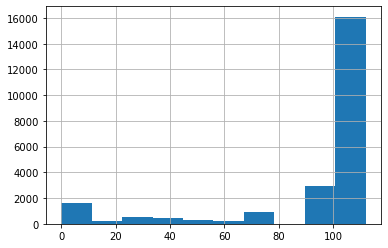

In [25]:
df['GD'].hist();

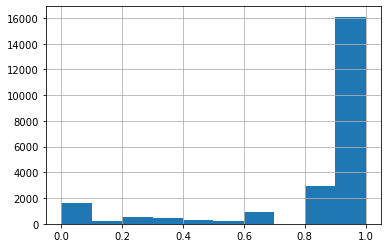

In [26]:
df['GD'] = standardize_01(df['GD'])
df['GD'] = df['GD'].astype(theano.config.floatX)
df['GD'].hist();

## Observed RI values from generative model (clade)

In [27]:
# True parameter values of generative linear function.  As much as possible, deriving these should follow the same
# pattern as the hyperpriors/priors of the Bayesian model.

# v0 and v1 derive from the same c, but each is linked to just one of a pair.  Each RI calc thus calls c twice.
# Split pairs to make species1 index and species2 index.  The key is having the node-species pair equal in both indices.
# Also make a clade1 and clade2 index.

# Each clade starts with a unique a and b, then pairs average them.  Therefore, they should be indexed by clade 
# intersections and the biogeo index.  Separate test is species or pair index.

a = 0.01 # Intercept
b = 0.01 # Slope
c = 0.01 # Velocity
err = 0.0015

In [28]:
# Get crown nodes for eight clades.
crowns = [
    gtree.get_mrca_idx_from_tip_labels(wildcard = "Quercus|Quercus"),
    gtree.get_mrca_idx_from_tip_labels(wildcard = "Quercus|Virentes"),
    gtree.get_mrca_idx_from_tip_labels(wildcard = "Quercus|Ponticae"),
    gtree.get_mrca_idx_from_tip_labels(wildcard = "Quercus|Protobalanus"),
    gtree.get_mrca_idx_from_tip_labels(wildcard = "Quercus|Lobatae"),
    gtree.get_mrca_idx_from_tip_labels(wildcard = "Cerris|Cyclobalanopsis"),
    gtree.get_mrca_idx_from_tip_labels(wildcard = "Cerris|Ilex"),
    gtree.get_mrca_idx_from_tip_labels(wildcard = "Cerris|Cerris")
]
crowns

[393, 394, 405, 417, 425, 426, 422, 423]

In [29]:
# Get clade specific scalars for intercept.
intercept_scalars = []
for num in crowns:
    height = gtree.idx_dict[num].height
    intercept_scalars.append(height)

intercept_scalars

[45.00000001000001,
 31.155833340000004,
 24.233750010000005,
 25.100625010000005,
 47.870000010000005,
 48.32000001000001,
 37.94300745800001,
 38.64576431700001]

In [30]:
# Get clade-specific scalars for slope.
import statistics
slope_scalars = []
for num in crowns:
    gc = gtree.copy()
    node = gc.get_feature_dict("idx")[num]
    subtree = toytree.tree(node)
    slope_scalars.append(statistics.mean(subtree.get_edge_values("dist")))

slope_scalars

[3.9291290390320985,
 31.15583334,
 24.23375,
 9.020537109375,
 1.9884064844037577,
 10.14750809212931,
 3.8535626106666667,
 10.2008888903]

In [31]:
# Get species-specific scalars for velocity.  Set this directly onto tree.
velocity_scalars = []
heights = gtree.get_feature_dict("idx", "height")
for idx in gtree.get_node_dict().keys():
    branch = heights.get(idx)
    if branch == 0:
         branch = 7.105427357601002e-15
    velocity_scalars.append(branch)
    
velocity_scalars

[1.0000007932831068e-08,
 2.000000165480742e-08,
 2.999996695507434e-09,
 6.999997026468918e-09,
 6.999997026468918e-09,
 9.000004297377018e-09,
 9.000004297377018e-09,
 9.000004297377018e-09,
 9.000004297377018e-09,
 9.000004297377018e-09,
 9.000004297377018e-09,
 9.000004297377018e-09,
 9.000004297377018e-09,
 8.000000661922968e-09,
 1.690000317466911e-08,
 1.690000317466911e-08,
 1.4700006545353972e-08,
 1.2699999274445872e-08,
 1.2699999274445872e-08,
 1.2699999274445872e-08,
 1.2699999274445872e-08,
 1.2699999274445872e-08,
 1.2699999274445872e-08,
 1.3600001125269046e-08,
 1.249999570518412e-08,
 1.249999570518412e-08,
 2.500001983207767e-09,
 2.500001983207767e-09,
 2.500001983207767e-09,
 2.500001983207767e-09,
 7.105427357601002e-15,
 7.105427357601002e-15,
 3.0000109063621494e-09,
 3.0000109063621494e-09,
 3.0000109063621494e-09,
 3.0000109063621494e-09,
 7.105427357601002e-15,
 7.105427357601002e-15,
 7.105427357601002e-15,
 2.0000072709080996e-09,
 3.0000109063621494e-09,
 

In [32]:
# Define base slope values at crowns.
intercepts = {
    393: a * intercept_scalars[0], # Quercus
    394: a * intercept_scalars[1], # Virentes
    405: a * intercept_scalars[2], # Ponticae
    417: a * intercept_scalars[3], # Protobalanus
    425: a * intercept_scalars[4], # Lobatae
    426: a * intercept_scalars[5], # Cyclobalanopsis
    422: a * intercept_scalars[6], # Ilex
    423: a * intercept_scalars[7], # Cerris
}

slopes = {
    393: b * slope_scalars[0], # Quercus
    394: b * slope_scalars[1], # Virentes
    405: b * slope_scalars[2], # Ponticae
    417: b * slope_scalars[3], # Protobalanus
    425: b * slope_scalars[4], # Lobatae
    426: b * slope_scalars[5], # Cyclobalanopsis
    422: b * slope_scalars[6], # Ilex
    423: b * slope_scalars[7], # Cerris
}

velocities = dict(zip(gtree.get_node_dict().keys(), velocity_scalars))

# For clade model: scale b in some way by the average length of the child tips of these nodes.

# For species model: assign from a single distribution instead.

In [33]:
# For each crown node: get descendants, then generate slopes from a clade-specific normal distribution.
rng = np.random.default_rng()
allslope = {}
for node in slopes:
    idxs = gtree.get_node_descendant_idxs(node)
    for idx in idxs:
        allslope.update({idx: rng.normal(slopes[node], 0.005)})
        
allslope

{393: 0.03601459020898815,
 379: 0.044076879993600444,
 378: 0.042094177184176,
 366: 0.040023403901766876,
 365: 0.033058352681707974,
 364: 0.0436271100486115,
 363: 0.04156362817741932,
 351: 0.042275040733840384,
 350: 0.04608175599636363,
 349: 0.03244667222996031,
 348: 0.03903319229453919,
 347: 0.03416640411700691,
 346: 0.034426974266843706,
 345: 0.04112153830368619,
 344: 0.028576871814528032,
 336: 0.03788064373615517,
 335: 0.042751162037775625,
 76: 0.04029865179534544,
 334: 0.03046954451001755,
 67: 0.03826705418775833,
 333: 0.03341515710137867,
 332: 0.03669194087131989,
 331: 0.04077309649926902,
 330: 0.04300960428922175,
 329: 0.03999092573643536,
 38: 0.04040992262212769,
 328: 0.041468746406278664,
 327: 0.04454898550619274,
 326: 0.04060481689410069,
 325: 0.040259847233748244,
 324: 0.04411575860385609,
 81: 0.04279281952364171,
 80: 0.04284314100668874,
 79: 0.03757585797026942,
 318: 0.042444414946478895,
 75: 0.03839048545340999,
 317: 0.04182760119856004,
 

In [34]:
# Generate intercepts.
allinter = {}
for node in intercepts:
    idxs = gtree.get_node_descendant_idxs(node)
    for idx in idxs:
        allinter.update({idx: rng.normal(intercepts[node], 0.001)})
        
allinter

{393: 0.4508745592857385,
 379: 0.44930113391869836,
 378: 0.4517975357400167,
 366: 0.4482636804831401,
 365: 0.45205870223202355,
 364: 0.4494951269793995,
 363: 0.4498248387627318,
 351: 0.44915109252184454,
 350: 0.45093497038380154,
 349: 0.447973404302155,
 348: 0.45004463909014025,
 347: 0.451085617019661,
 346: 0.44992194742344793,
 345: 0.4501910024831458,
 344: 0.45022770731837386,
 336: 0.44990118495331044,
 335: 0.44942537076640543,
 76: 0.44956113295774003,
 334: 0.44996061545003263,
 67: 0.4497461752203006,
 333: 0.4503992257172217,
 332: 0.44982554582099615,
 331: 0.45083994167465374,
 330: 0.45017527891928,
 329: 0.4508347408371191,
 38: 0.4502105725286592,
 328: 0.4487108898489512,
 327: 0.44947083157433926,
 326: 0.44652603102703986,
 325: 0.4496648318254584,
 324: 0.4520572150324842,
 81: 0.44893372722389385,
 80: 0.4502501330896118,
 79: 0.4494341048850113,
 318: 0.45067992984421607,
 75: 0.4489329746652395,
 317: 0.449709104097373,
 66: 0.45006230694045973,
 65: 0.

In [35]:
# Generate velocities.
allvelo = {}
for idx in gtree.get_node_dict().keys():
    allvelo.update({idx: rng.normal((c * velocities.get(idx)), 0.001)})
    
allvelo

{215: -0.0015610962398741278,
 214: -0.0010670374637839531,
 213: -0.0008180946670689748,
 212: 0.0017042406654161257,
 211: 0.00019339171784611348,
 210: 0.0004174609088828683,
 209: 0.0030707823162482136,
 208: 0.0005439786368292571,
 207: -0.002017383598916403,
 206: 1.2188898372654775e-05,
 205: -0.0002812966134647987,
 204: 0.0007685428997706867,
 203: 0.0015203853110988192,
 202: 0.0006921226302864892,
 201: 0.0002624307933752852,
 200: -0.0006567567378095732,
 199: 0.0016918479951812087,
 198: -0.0009226741606297193,
 197: 0.0010352032268030698,
 196: 0.0016859215666795995,
 195: -0.0007390836337324166,
 194: -0.0004937588450595647,
 193: 0.001156588090988573,
 192: 0.001544452719210606,
 191: 0.00018855405956353963,
 190: -0.00118937191730146,
 189: 0.0014299588672735866,
 188: -0.0007542207799586638,
 187: 0.0002361836304781394,
 186: 0.001405114596504523,
 185: -5.961797526442639e-05,
 184: 0.000398249387660304,
 183: 0.0004214549159779152,
 182: -0.00037279328981066235,
 181

In [36]:
# Set values on tree.
gtree = gtree.set_node_values("intercept", allinter)
gtree = gtree.set_node_values("slope", allslope)
gtree = gtree.set_node_values("velocity", allvelo)

# Assign clade colors to nodes (for tree visual).
for node, color in zip(velocities.keys(), toytree.colors[:8]):
    for idx in gtree.get_node_descendant_idxs(node):
        gtree.idx_dict[idx].color = color

In [37]:
# Iterate to fill RI values.
for idx in df.index:
    
    # Get node indices.
    idx0 = df.loc[idx, "Pairs"][0]
    idx1 = df.loc[idx, "Pairs"][1]
    
    # Get node velocities.
    v0 = gtree.idx_dict[idx0].velocity
    v1 = gtree.idx_dict[idx1].velocity
    
    # Get node intercepts.
    a_avg = (gtree.idx_dict[idx0].intercept + gtree.idx_dict[idx1].intercept) / 2
    
    # Get node slopes.
    b_avg = (gtree.idx_dict[idx0].slope + gtree.idx_dict[idx1].slope) / 2
    
    # Generate error.
    error = rng.normal(0, err)
    
    # Calculate RI.
    ri = a_avg + ((b_avg + v0 + v1) * (df.loc[idx, "GD"] / 2.0)) + error 
    
    # Store RI value in dataframe.
    df.loc[idx, "Observed_RI"] = ri
    
df['Observed_RI'] = df['Observed_RI'].astype(theano.config.floatX)

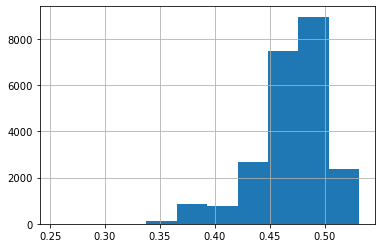

In [38]:
df['Observed_RI'].hist();

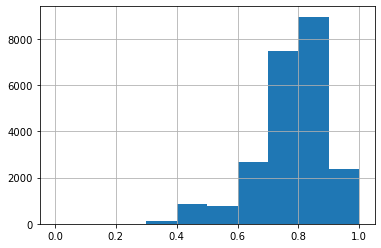

In [39]:
df['Observed_RI'] = standardize_01(df['Observed_RI']) 
df['Observed_RI'].hist();

In [40]:
df

,Pairs,Range_pairs,Species1,Species1_index,Clade1,Clade1_index,Species2,Species2_index,Clade2,Clade2_index,Clade_duo,Clade_duo_index,Overlap,GD,Lit,Observed_RI
0,"(215, 214)",((POLYGON ...,Quercus aj...,215,Quercus,0,Quercus tu...,214,Quercus,0,Quercus + ...,0,1,0.575711,NaN,0.564411
1,"(215, 213)",((POLYGON ...,Quercus aj...,215,Quercus,0,Quercus to...,213,Quercus,0,Quercus + ...,0,1,0.690100,NaN,0.589688
2,"(215, 212)",((POLYGON ...,Quercus aj...,215,Quercus,0,Quercus ob...,212,Quercus,0,Quercus + ...,0,1,0.690100,NaN,0.600000
3,"(215, 211)",((POLYGON ...,Quercus aj...,215,Quercus,0,Quercus ch...,211,Quercus,0,Quercus + ...,0,1,0.690100,NaN,0.586087
4,"(215, 210)",((POLYGON ...,Quercus aj...,215,Quercus,0,Quercus gr...,210,Quercus,0,Quercus + ...,0,1,0.690100,NaN,0.597041
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23215,"(3, 1)",(POLYGON (...,Quercus br...,3,Cerris,7,Quercus ac...,1,Cerris,7,Cerris + C...,35,0,0.028209,NaN,0.709417
23216,"(3, 0)",(POLYGON (...,Quercus br...,3,Cerris,7,Quercus ch...,0,Cerris,7,Cerris + C...,35,0,0.028209,NaN,0.698078
23217,"(2, 1)",((POLYGON ...,Quercus it...,2,Cerris,7,Quercus ac...,1,Cerris,7,Cerris + C...,35,0,0.014100,NaN,0.710615
23218,"(2, 0)",((POLYGON ...,Quercus it...,2,Cerris,7,Quercus ch...,0,Cerris,7,Cerris + C...,35,0,0.014100,NaN,0.709511


In [41]:
dfs = df.sample(frac = 0.02)
dfs

,Pairs,Range_pairs,Species1,Species1_index,Clade1,Clade1_index,Species2,Species2_index,Clade2,Clade2_index,Clade_duo,Clade_duo_index,Overlap,GD,Lit,Observed_RI
18252,"(100, 17)",(POLYGON (...,Quercus sc...,100,Lobatae,4,Quercus ro...,17,Ilex,6,Lobatae + ...,28,0,0.927410,NaN,0.816624
16891,"(113, 0)",(POLYGON (...,Quercus ux...,113,Lobatae,4,Quercus ch...,0,Cerris,7,Lobatae + ...,29,0,0.927410,NaN,0.804892
14193,"(134, 115)",(POLYGON (...,Quercus pr...,134,Quercus,0,Quercus el...,115,Lobatae,4,Quercus + ...,4,0,0.025319,NaN,0.817023
10899,"(157, 74)",(POLYGON (...,Quercus fabri,157,Quercus,0,Quercus in...,74,Lobatae,4,Quercus + ...,4,0,0.927410,NaN,0.804674
7312,"(178, 154)",(POLYGON (...,Quercus ha...,178,Quercus,0,Quercus yu...,154,Quercus,0,Quercus + ...,0,0,1.000000,NaN,0.923174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19147,"(90, 67)",(POLYGON (...,Quercus ca...,90,Lobatae,4,Quercus el...,67,Lobatae,4,Lobatae + ...,26,0,0.896450,NaN,0.446861
2269,"(205, 40)",(POLYGON (...,Quercus ob...,205,Quercus,0,Quercus ox...,40,Cyclobalan...,5,Quercus + ...,5,0,1.000000,NaN,0.711133
8112,"(174, 56)",(POLYGON (...,Quercus hi...,174,Quercus,0,Quercus fl...,56,Cyclobalan...,5,Quercus + ...,5,0,1.000000,NaN,0.902528
9394,"(166, 130)",((POLYGON ...,Quercus in...,166,Quercus,0,Quercus sa...,130,Ponticae,2,Quercus + ...,2,0,1.000000,NaN,0.904383


In [42]:
nsub_pairs = len(dfs.Pairs)
# nsub_clade_duo = len(dfs.Clade_duo.unique())

s1_idx = dfs.Species1_index.values
s2_idx = dfs.Species2_index.values
clade1_idx = dfs.Clade1_index.values
clade2_idx = dfs.Clade2_index.values
clade_duo_idx = dfs.Clade_duo_index.values

# litsub_idx = dfs.Lit.values
bgsub_idx = dfs.Overlap.values

In [43]:
# Defining variables for model.
coords = {
    "Pairs" : np.arange(dfs.Pairs.size), # Array for each pair
    #"Clade1" : dfs.Clade1.values, # for pm.Data
    #"Clade2" : dfs.Clade2.values, # for pm.Data
    "Species1" : dfs.Species1,
    "Species2" : dfs.Species2,
    "Biogeo" : dfs.Overlap,
    "Clade_intersect" : dfs.Clade_duo
}

# a/b have double index of biogeo and clade intersect
# c indexes by either clades or species
# have four pm.Data objects: a/b vary by first two indices, c by last 2
# the objects themselves vary by pairs, so does final likelihood

## Non-centered hierarchical model with subsampling

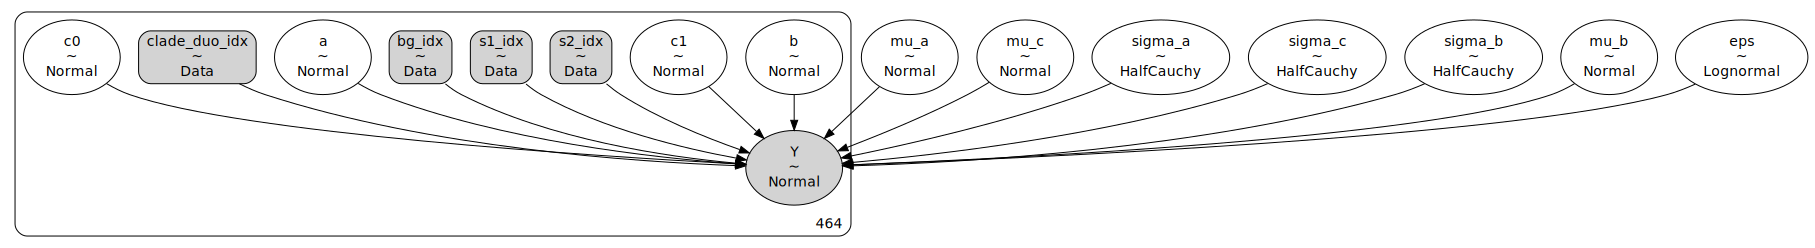

In [79]:
# Build model.
with pm.Model(coords = coords) as hier_nc:
    
    # Data objects.
    clade_duo_idx = pm.Data("clade_duo_idx", dfs.Clade_duo_index.values, dims = "Clade_intersect") # Intersect value per pair in data
    bg_idx = pm.Data("bg_idx", dfs.Overlap.values, dims = "Biogeo") # Overlap value per pair in data
    s1_idx = pm.Data("s1_idx", dfs.Species1_index.values, dims = "Species1") # First species index per pair in data
    s2_idx = pm.Data("s2_idx", dfs.Species2_index.values, dims = "Species2") # Second species index per pair in data

    # Hyperpriors.
    mu_a = pm.Normal("mu_a", mu = 0.0, sd = 1.0) # Intercept hyperprior
    sigma_a = pm.HalfCauchy("sigma_a", 1.0)
    mu_b = pm.Normal("mu_b", mu = 0.0, sd = 1.0) # Slope hyperprior
    sigma_b = pm.HalfCauchy("sigma_b", 5.0)
    mu_c = pm.Normal("mu_c", mu = 0.0, sd = 1.0) # Velocity hyperprior
    sigma_c = pm.HalfCauchy("sigma_c", 1.0)
        
    # Priors.  Dims options: species, clades or clade intersections.
    a = pm.Normal("a", mu = 0, sd = 1, dims = "Pairs") # Vary intercept by clade intersections
    b = pm.Normal("b", mu = 0, sd = 1, dims = "Pairs") # Vary slope by clade intersections
    c0 = pm.Normal("c0", mu = 0, sd = 1, dims = "Pairs") # Vary velocities by species names
    c1 = pm.Normal("c1", mu = 0, sd = 1, dims = "Pairs") # Vary velocities by species names
    
    # Linear equation.
    RI_est = (mu_a + a[clade_duo_idx][bg_idx] * sigma_a) + (((mu_b + b[clade_duo_idx][bg_idx] * sigma_b) + 
                                    (mu_c + c0[s1_idx] * sigma_c) + 
                                    (mu_c + c1[s2_idx] * sigma_c)) * (dfs.GD.values / 2))
        
    # Error term.
    eps = pm.Lognormal("eps", mu = -1.0, sigma = 1.0)
        
    # Data likelihood.
    Y = pm.Normal("Y", RI_est, sigma = eps, observed = dfs.Observed_RI.values, dims = "Pairs")
    
# Visualize model.  (For paper, maybe graph the centered equivalent.)
pm.model_to_graphviz(hier_nc)

In [80]:
with hier_nc:
    trace = pm.sample(1000, tune = 500, target_accept = 0.99, chains = 2, cores = 8)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 8 jobs)
NUTS: [eps, c1, c0, b, a, sigma_c, mu_c, sigma_b, mu_b, sigma_a, mu_a]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 691 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


In [82]:
with hier_nc:
    trace = pm.sample(1000, tune = 1000, target_accept = 0.99, chains = 2, cores = 8)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 8 jobs)
NUTS: [eps, c1, c0, b, a, sigma_c, mu_c, sigma_b, mu_b, sigma_a, mu_a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 902 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [85]:
with hier_nc:
    trace = pm.sample(1000, tune = 500, target_accept = 0.99, max_treedepth = 12, chains = 2, cores = 8)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 8 jobs)
NUTS: [eps, c1, c0, b, a, sigma_c, mu_c, sigma_b, mu_b, sigma_a, mu_a]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 2875 seconds.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


In [88]:
with hier_nc:
    trace = pm.sample(1000, tune = 1500, target_accept = 0.99, max_treedepth = 13, chains = 2, cores = 8)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 8 jobs)
NUTS: [eps, c1, c0, b, a, sigma_c, mu_c, sigma_b, mu_b, sigma_a, mu_a]


Sampling 2 chains for 1_500 tune and 1_000 draw iterations (3_000 + 2_000 draws total) took 9904 seconds.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


In [90]:
with hier_nc:
    trace = pm.sample(1000, tune = 2000, target_accept = 0.99, max_treedepth = 13, chains = 2, cores = 8)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 8 jobs)
NUTS: [eps, c1, c0, b, a, sigma_c, mu_c, sigma_b, mu_b, sigma_a, mu_a]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 12662 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


In [92]:
with hier_nc:
    trace = pm.sample(1000, tune = 1000, target_accept = 0.99, max_treedepth = 15, chains = 2, cores = 8)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 8 jobs)
NUTS: [eps, c1, c0, b, a, sigma_c, mu_c, sigma_b, mu_b, sigma_a, mu_a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 9743 seconds.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [ ]:
with hier_nc:
    trace = pm.sample(1000, tune = 2000, target_accept = 0.99, max_treedepth = 20, chains = 2, cores = 8)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 8 jobs)
NUTS: [eps, c1, c0, b, a, sigma_c, mu_c, sigma_b, mu_b, sigma_a, mu_a]


In [93]:
pm.summary(trace, var_names = ["sigma_a", "mu_a", "sigma_b", "mu_b", "sigma_c", "mu_c"])
# pm.summary(trace, var_names = ["c1"])

/home/henry/miniconda3/envs/py37/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
sigma_a,0.324,0.556,0.000,1.183,0.041,0.029,185.0,185.0,214.0,253.0,1.01
mu_a,0.690,0.356,-0.099,1.206,0.034,0.024,113.0,113.0,242.0,95.0,1.00
sigma_b,0.725,1.186,0.000,2.770,0.044,0.031,713.0,713.0,413.0,928.0,1.01
mu_b,-0.046,0.897,-1.780,1.575,0.021,0.019,1871.0,1149.0,1877.0,1554.0,1.00
sigma_c,0.182,0.008,0.166,0.197,0.000,0.000,341.0,341.0,341.0,531.0,1.01
mu_c,-0.013,0.503,-0.913,0.960,0.014,0.011,1382.0,1088.0,1397.0,1147.0,1.00


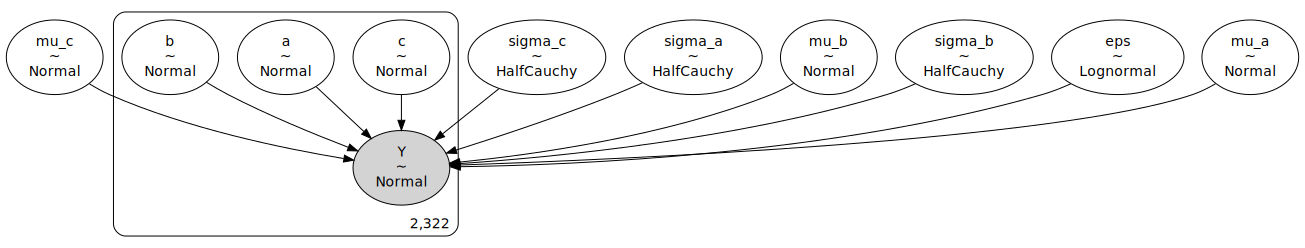

In [168]:
# Old: trying something new above.
# Build hierarchical model.
with pm.Model() as hier_nc:

    # Hyperpriors.
    mu_a = pm.Normal("mu_a", mu=0.0, sd=1.0) # Intercept hyperprior
    sigma_a = pm.HalfCauchy("sigma_a", 1.0)
    mu_b = pm.Normal("mu_b", mu=0.0, sd=1.0) # Slope hyperprior
    sigma_b = pm.HalfCauchy("sigma_b", 5.0)
    mu_c = pm.Normal("mu_c", mu=0.0, sd=1.0) # Velocity hyperprior
    sigma_c = pm.HalfCauchy("sigma_c", 1.0)
        
    # Priors. 
    a = pm.Normal("a", mu=0, sd=1, shape=nsub_pairs)
    b = pm.Normal("b", mu=0, sd=1, shape=nsub_pairs)
    c = pm.Normal("c", mu=0, sd=1, shape=nsub_pairs)
    
    # Linear equation.
    RI_est = (mu_a + a[bgsub_idx][clade_duo_idx] * sigma_a) + (((mu_b + b[bgsub_idx][clade_duo_idx] * sigma_b) + 
                                    (mu_c + c[s1_idx] * sigma_c) + 
                                    (mu_c + c[s2_idx] * sigma_c)) * (dfs.GD.values / 2))
        
    # Error term.
    eps = pm.Lognormal("eps", mu=-1.0, sigma=1.0)
        
    # Data likelihood.
    Y = pm.Normal("Y", RI_est, sigma=eps, observed=dfs.Observed_RI.values)
    
# Visualize model.  (For paper, maybe graph the centered equivalent.)
pm.model_to_graphviz(hier_nc)

# Final Y values: take means of four variables and GD for all pairs, calculate Y, add that to heatmap.

In [173]:
with hier_nc:
    trace = pm.sample(1000, tune = 1000, target_accept = 0.99, max_treedepth = 15, chains = 2, cores = 8)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 8 jobs)
NUTS: [eps, c, b, a, sigma_c, mu_c, sigma_b, mu_b, sigma_a, mu_a]


Sampling 1 chain for 1_000 tune and 189 draw iterations (1_000 + 189 draws total) took 11788 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [172]:
pm.summary(trace, var_names = ["sigma_a", "mu_a", "sigma_b", "mu_b", "sigma_c", "mu_c"])

/home/henry/miniconda3/envs/py37/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
sigma_a,0.363,0.544,0.012,1.140,0.044,0.031,153.0,153.0,143.0,303.0,1.02
mu_a,0.751,0.318,0.040,1.188,0.033,0.023,95.0,95.0,99.0,133.0,1.03
sigma_b,0.945,1.344,0.007,3.187,0.078,0.055,295.0,295.0,184.0,323.0,1.01
mu_b,0.038,0.856,-1.466,1.762,0.057,0.041,223.0,223.0,222.0,459.0,1.00
sigma_c,0.158,0.008,0.144,0.174,0.002,0.002,11.0,11.0,12.0,30.0,1.16
mu_c,-0.039,0.510,-0.964,0.963,0.038,0.027,177.0,177.0,179.0,260.0,1.00


## Censored regression example

In [68]:
m, c, σ, N = 1, 0, 2, 200
x = np.random.uniform(-10, 10, N)
y = np.random.normal(m * x + c, σ)
bounds = [-5, 5]

def censored_regression(x, y, bounds):
    
    # data pre-processing
    left_censored = (y <= bounds[0])
    x_lc = x[left_censored]
    y_lc = y[left_censored]
    
    right_censored = (y >= bounds[1])
    x_rc = x[right_censored]
    y_rc = y[right_censored]
    
    uncensored = (y>bounds[0]) & (y<bounds[1])
    x = x[uncensored]
    y = y[uncensored]

    with pm.Model() as model:
        m = pm.Normal("m", mu=0, sd=1)
        k = pm.Normal("k", mu=0, sd=1)
        c = pm.Normal("c", mu=0, sd=1)
        σ = pm.HalfNormal("σ", sd=1)
        y_likelihood = pm.Normal("y_likelihood", mu=(m + k) * x + c, sd=σ, observed=y)
        left_censored = pm.Potential("left_censored", normal_lcdf((m + k) * x_lc + c, σ, y_lc))
        right_censored = pm.Potential("right_censored", normal_lccdf((m + k) * x_rc + c, σ, y_rc))

    with model:
        trace = pm.sample()

    return model, trace

In [69]:
censored_regression(x, y, bounds)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, c, k, m]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 40 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8803248089320832, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6863332790090424, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


(<pymc3.model.Model at 0x7f914a9c2710>,
 <MultiTrace: 4 chains, 1000 iterations, 5 variables>)

## Subsampled non-centered hierarchical model with censoring

In [ ]:
nsub_pairs = len(dfs.Pairs)
# nsub_clade_duo = len(dfs.Clade_duo.unique())

s1_idx = dfs.Species1_index.values
s2_idx = dfs.Species2_index.values
clade1_idx = dfs.Clade1_index.values
clade2_idx = dfs.Clade2_index.values
clade_duo_idx = dfs.Clade_duo_index.values

# litsub_idx = dfs.Lit.values
bg_idx = dfs.Overlap.values

In [239]:
def hierarchical_censored_regression(x, y, bounds):
    
    # Data pre-processing.
    left_censored = (y <= bounds[0])
    x_lc = x[left_censored]
    y_lc = y[left_censored]
    nsub_pairs_lc = len(dfs.Pairs[left_censored])
    bg_idx_lc = dfs.Overlap.values[left_censored]
    s1_idx_lc = dfs.Species1_index.values[left_censored]
    s2_idx_lc = dfs.Species2_index.values[left_censored]
    clade1_idx_lc = dfs.Clade1_index.values[left_censored]
    clade2_idx_lc = dfs.Clade2_index.values[left_censored]
    clade_duo_idx_lc = dfs.Clade_duo_index.values[left_censored]
    print(len(x_lc), len(y_lc), nsub_pairs_lc, len(bg_idx_lc), len(s1_idx_lc), len(s2_idx_lc),
          len(clade1_idx_lc), len(clade2_idx_lc), len(clade_duo_idx_lc))
    
    right_censored = (y >= bounds[1])
    x_rc = x[right_censored]
    y_rc = y[right_censored]
    nsub_pairs_rc = len(dfs.Pairs[right_censored])
    bg_idx_rc = dfs.Overlap.values[right_censored]
    s1_idx_rc = dfs.Species1_index.values[right_censored]
    s2_idx_rc = dfs.Species2_index.values[right_censored]
    clade1_idx_rc = dfs.Clade1_index.values[right_censored]
    clade2_idx_rc = dfs.Clade2_index.values[right_censored]
    clade_duo_idx_rc = dfs.Clade_duo_index.values[right_censored]
    print(len(x_rc), len(y_rc), nsub_pairs_rc, len(bg_idx_rc), len(s1_idx_rc), len(s2_idx_rc),
          len(clade1_idx_rc), len(clade2_idx_rc), len(clade_duo_idx_rc))
    
    uncensored = (y>bounds[0]) & (y<bounds[1])
    x = x[uncensored]
    y = y[uncensored]
    nsub_pairs_u = len(dfs.Pairs[uncensored])
    bg_idx_u = dfs.Overlap.values[uncensored]
    s1_idx_u = dfs.Species1_index.values[uncensored]
    s2_idx_u = dfs.Species2_index.values[uncensored]
    clade1_idx_u = dfs.Clade1_index.values[uncensored]
    clade2_idx_u = dfs.Clade2_index.values[uncensored]
    clade_duo_idx_u = dfs.Clade_duo_index.values[uncensored]
    print(len(x), len(y), nsub_pairs_u, len(bg_idx_u), len(s1_idx_u), len(s2_idx_u),
          len(clade1_idx_u), len(clade2_idx_u), len(clade_duo_idx_u))
    
    with pm.Model() as model:
    
        # Hyperpriors.
        mu_a = pm.Normal("mu_a", mu=0.0, sd=10.0) # Intercept hyperprior
        sigma_a = pm.HalfCauchy("sigma_a", 5.0)
        mu_b = pm.Normal("mu_b", mu=0.0, sd=1.0) # Slope hyperprior
        sigma_b = pm.HalfCauchy("sigma_b", 1.0)
        mu_c = pm.Normal("mu_c", mu=0.0, sd=1.0) # Velocity hyperprior
        sigma_c = pm.HalfCauchy("sigma_c", 1.0)
        
        # Priors for uncensored data. 
        a = pm.Normal("a", mu=0, sd=1, shape=nsub_pairs_u)
        b = pm.Normal("b", mu=0, sd=1, shape=nsub_pairs_u)
        c = pm.Normal("c", mu=0, sd=1, shape=nsub_pairs_u)
        
        # Priors for left censored data. 
        a_lc = pm.Normal("a_lc", mu=0, sd=1, shape=nsub_pairs_lc)
        b_lc = pm.Normal("b_lc", mu=0, sd=1, shape=nsub_pairs_lc)
        c_lc = pm.Normal("c_lc", mu=0, sd=1, shape=nsub_pairs_lc)
        
        # Priors for right censored data. 
        a_rc = pm.Normal("a_rc", mu=0, sd=1, shape=nsub_pairs_rc)
        b_rc = pm.Normal("b_rc", mu=0, sd=1, shape=nsub_pairs_rc)
        c_rc = pm.Normal("c_rc", mu=0, sd=1, shape=nsub_pairs_rc)
        
        # Linear equation.
        RI_est = (mu_a + a[bg_idx_u][clade_duo_idx_u] * sigma_a) + (((mu_b + b[bg_idx_u][clade_duo_idx_u] * sigma_b) + 
                                        (mu_c + c[clade1_idx_u] * sigma_c) + 
                                        (mu_c + c[clade2_idx_u] * sigma_c)) * (x / 2))
        
        # Error term.
        eps = pm.Lognormal("eps", mu=-1.0, sigma=1.0)
        
        # Data likelihood.
        Y = pm.Normal("Y", RI_est, sigma=eps, observed=y)
        
        # Left censoring.
        left_censored = pm.Potential("left_censored", normal_lcdf((mu_a + a_lc[bg_idx_lc][clade_duo_idx_lc] * sigma_a) + 
                                                                  (((mu_b + b_lc[bg_idx_lc][clade_duo_idx_lc] * sigma_b) + 
                                                                    (mu_c + c_lc[clade1_idx_lc] * sigma_c) + 
                                                                    (mu_c + c_lc[clade2_idx_lc] * sigma_c)) * (x_lc / 2)),
                                                                 eps, y_lc))
        
        # Right censoring.
        right_censored = pm.Potential("right_censored", normal_lccdf((mu_a + a_rc[bg_idx_rc][clade_duo_idx_rc] * sigma_a) + 
                                                                  (((mu_b + b_rc[bg_idx_rc][clade_duo_idx_rc] * sigma_b) + 
                                                                    (mu_c + c_rc[clade1_idx_rc] * sigma_c) + 
                                                                    (mu_c + c_rc[clade2_idx_rc] * sigma_c)) * (x_rc / 2)),
                                                                    eps, y_rc))
        
    graph = pm.model_to_graphviz(model)
                                     
    with model:
        trace = pm.sample(1000, tune = 2000, target_accept = 0.99, max_treedepth = 12, chains = 2, cores = 8)

    return model, graph, trace

In [187]:
# trace = pm.sample(1000, tune = 1000, target_accept = 0.99, chains = 2, cores = 8)
# a/b indexed, new non-centering
hcmodel, hgraph, hctrace = hierarchical_censored_regression(dfs.GD.values, dfs.Observed_RI.values, [0, 1])

653 653 653 653 653 653 653
29 29 29 29 29 29 29
1640 1640 1640 1640 1640 1640 1640


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 8 jobs)
NUTS: [eps, c_rc, b_rc, a_rc, c_lc, b_lc, a_lc, c, b, a, sigma_c, mu_c, sigma_b, mu_b, sigma_a, mu_a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3662 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


In [191]:
# trace = pm.sample(1000, tune = 2000, target_accept = 0.99, chains = 2, cores = 8)
# a/b indexed, new non-centering
# similar results (4-6 div) with wider a hyper, may just be noise
# treedepth = 12 is min
hcmodel, hgraph, hctrace = hierarchical_censored_regression(dfs.GD.values, dfs.Observed_RI.values, [0, 1])

653 653 653 653 653 653 653
29 29 29 29 29 29 29
1640 1640 1640 1640 1640 1640 1640


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 8 jobs)
NUTS: [eps, c_rc, b_rc, a_rc, c_lc, b_lc, a_lc, c, b, a, sigma_c, mu_c, sigma_b, mu_b, sigma_a, mu_a]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 5307 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


In [235]:
# trace = pm.sample(1000, tune = 1500, target_accept = 0.99, max_treedepth = 11, chains = 2, cores = 8)
hcmodel, hgraph, hctrace = hierarchical_censored_regression(dfs.GD.values, dfs.Observed_RI.values, [0, 1])

653 653 653 653 653 653 653 653 653
29 29 29 29 29 29 29 29 29
1640 1640 1640 1640 1640 1640 1640 1640 1640


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 8 jobs)
NUTS: [eps, c_rc, b_rc, a_rc, c_lc, b_lc, a_lc, c, b, a, sigma_c, mu_c, sigma_b, mu_b, sigma_a, mu_a]


Sampling 2 chains for 1_500 tune and 1_000 draw iterations (3_000 + 2_000 draws total) took 6920 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9640769369504572, but should be close to 0.99. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9580242815143802, but should be close to 0.99. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


In [236]:
pm.summary(hctrace, var_names = ['sigma_c', 'mu_c', 'sigma_b', 'mu_b', 'sigma_a', 'mu_a'])
# pm.summary(hctrace, var_names = ['c'])['r_hat'].hist();

/home/henry/miniconda3/envs/py37/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
sigma_c,0.130,0.060,0.040,0.234,0.004,0.003,196.0,196.0,178.0,251.0,1.01
mu_c,0.981,0.572,-0.214,2.093,0.053,0.038,115.0,115.0,129.0,112.0,1.01
sigma_b,1.033,1.467,0.000,3.109,0.109,0.077,183.0,183.0,91.0,163.0,1.00
mu_b,0.611,0.901,-0.998,2.319,0.062,0.044,212.0,212.0,212.0,401.0,1.01
sigma_a,5.990,4.598,0.760,15.294,0.526,0.373,77.0,77.0,93.0,156.0,1.04
mu_a,-2.466,3.696,-9.366,4.248,0.586,0.446,40.0,35.0,47.0,44.0,1.07


In [240]:
# trace = pm.sample(1000, tune = 2000, target_accept = 0.99, max_treedepth = 12, chains = 2, cores = 8)
hcmodel, hgraph, hctrace = hierarchical_censored_regression(dfs.GD.values, dfs.Observed_RI.values, [0, 1])

653 653 653 653 653 653 653 653 653
29 29 29 29 29 29 29 29 29
1640 1640 1640 1640 1640 1640 1640 1640 1640


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 8 jobs)
NUTS: [eps, c_rc, b_rc, a_rc, c_lc, b_lc, a_lc, c, b, a, sigma_c, mu_c, sigma_b, mu_b, sigma_a, mu_a]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 11945 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9706254288533336, but should be close to 0.99. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Runs from older setup below.

In [82]:
# trace = pm.sample(1000, tune = 500, target_accept = 0.95, chains = 2, cores = 8) - new gen math and related changes
# pm.summary(hctrace, var_names = ['sigma_c', 'mu_c', 'sigma_b', 'mu_b', 'sigma_a', 'mu_a'])
# sigma_a: ~1.3 rhat at 5, 1.61 at 1, 1.09 at 50, 1.23 at 100 (there for now)
hcmodel, hctrace = hierarchical_censored_regression(dfs.GD.values, dfs.Observed_RI.values, [0, 1])

653 653 653 653 653 653 653
29 29 29 29 29 29 29
1640 1640 1640 1640 1640 1640 1640


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 8 jobs)
NUTS: [eps, c1r_offset, c0r_offset, br_offset, ar_offset, c1l_offset, c0l_offset, bl_offset, al_offset, c1_offset, c0_offset, b_offset, a_offset, sigma_c, mu_c, sigma_b, mu_b, sigma_a, mu_a]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 1764 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


In [104]:
# trace = pm.sample(1000, tune = 500, target_accept = 0.98, chains = 2, cores = 8) - new gen math and related changes, SA100
hcmodel, hctrace = hierarchical_censored_regression(dfs.GD.values, dfs.Observed_RI.values, [0, 1])

653 653 653 653 653 653 653
29 29 29 29 29 29 29
1640 1640 1640 1640 1640 1640 1640


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 8 jobs)
NUTS: [eps, c1r_offset, c0r_offset, br_offset, ar_offset, c1l_offset, c0l_offset, bl_offset, al_offset, c1_offset, c0_offset, b_offset, a_offset, sigma_c, mu_c, sigma_b, mu_b, sigma_a, mu_a]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 1758 seconds.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


In [139]:
# trace = pm.sample(1000, tune = 500, target_accept = 0.98, chains = 2, cores = 8)
# after noticing that intercept/slope were mixed up, SA50 SB10
hcmodel, hctrace = hierarchical_censored_regression(dfs.GD.values, dfs.Observed_RI.values, [0, 1])

653 653 653 653 653 653 653
29 29 29 29 29 29 29
1640 1640 1640 1640 1640 1640 1640


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 8 jobs)
NUTS: [eps, c1r_offset, c0r_offset, br_offset, ar_offset, c1l_offset, c0l_offset, bl_offset, al_offset, c1_offset, c0_offset, b_offset, a_offset, sigma_c, mu_c, sigma_b, mu_b, sigma_a, mu_a]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 3575 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


In [152]:
# trace = pm.sample(1000, tune = 500, target_accept = 0.98, chains = 2, cores = 8)
# SA50 SB10 fixed error in censored equations
hcmodel, hctrace = hierarchical_censored_regression(dfs.GD.values, dfs.Observed_RI.values, [0, 1])

653 653 653 653 653 653 653
29 29 29 29 29 29 29
1640 1640 1640 1640 1640 1640 1640


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 8 jobs)
NUTS: [eps, c1r_offset, c0r_offset, br_offset, ar_offset, c1l_offset, c0l_offset, bl_offset, al_offset, c1_offset, c0_offset, b_offset, a_offset, sigma_c, mu_c, sigma_b, mu_b, sigma_a, mu_a]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 2971 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


## Run non-centered hierarchical model with full dataset and censoring

In [ ]:
npairs = len(pairs)
nclades = len(df.Clades.unique())
lit_idx = df.Lit.values
bg_idx = df.Overlap.values
clade_idx = df.Clade_index.values

In [35]:
# Build hierarchical model.
with pm.Model() as hierarchical_model:
    
    # Hyperpriors for group nodes.
    mu_a = pm.Normal("mu_a", mu=0.0, sigma=1.0) # Slope hyperprior
    sigma_a = pm.HalfNormal("sigma_a", 5.0)
    mu_b = pm.Normal("mu_b", mu=0.0, sigma=1.0) # Intercept hyperprior
    sigma_b = pm.HalfNormal("sigma_b", 1.0)
    mu_c0 = pm.Normal("mu_c0", mu=0.0, sigma=1.0) # C0 hyperprior
    sigma_c0 = pm.HalfNormal("sigma_c0", 1.0)
    mu_c1 = pm.Normal("mu_c1", mu=0.0, sigma=1.0) # C1 hyperprior
    sigma_c1 = pm.HalfNormal("sigma_c1", 1.0)
    
    # Regular priors.
    a = pm.Normal("a", mu=mu_a, sigma=sigma_a, shape=npairs) # Clades for clade model, pairs for species model
    b = pm.Normal("b", mu=mu_b, sigma=sigma_b, shape=npairs)
    c0 = pm.Normal("c0", mu=mu_c0, sigma=sigma_c0, shape=npairs)
    c1 = pm.Normal("c1", mu=mu_c1, sigma=sigma_c1, shape=npairs)
    
    # Error term.
    eps = pm.Lognormal("eps", mu=-1.0, sigma=1.0)
    
    # Build linear equation.
    RI_est = a[bg_idx][clade_idx] + (b + c0 + c1)[bg_idx][clade_idx] * df.GD.values
    
    # Data likelihood.
    Y = pm.Normal("Y", RI_est, sigma=eps, observed=df.Observed_RI.values)

In [36]:
# Inference button (TM)!
with hierarchical_model:
    hierarchical_trace = pm.sample(2000, target_accept = 0.9, chains = 2, cores = 4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [eps, c1, c0, b, a, sigma_c1, mu_c1, sigma_c0, mu_c0, sigma_b, mu_b, sigma_a, mu_a]


ValueError: Not enough samples to build a trace.

In [33]:
# Inference button (TM)!
with hierarchical_model:
    hierarchical_trace = pm.sample(2000, chains = 2, cores = 4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [eps, c1, c0, b, a, sigma_c1, mu_c1, sigma_c0, mu_c0, sigma_b, mu_b, sigma_a, mu_a]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 8762 seconds.
The acceptance probability does not match the target. It is 0.9225032298294525, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [34]:
pm.summary(hierarchical_trace, var_names = ['a', 'b', 'c0', 'c1'])

/home/henry/miniconda3/envs/py37/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],0.013,0.000,0.013,0.013,0.000,0.000,20.0,20.0,22.0,42.0,1.10
a[1],0.014,0.000,0.014,0.014,0.000,0.000,68.0,68.0,64.0,172.0,1.22
a[2],0.243,0.697,-0.569,0.940,0.491,0.416,2.0,2.0,2.0,19.0,2.99
a[3],0.446,0.537,-0.100,0.996,0.379,0.321,2.0,2.0,3.0,12.0,2.24
a[4],-0.163,0.751,-0.924,0.609,0.530,0.449,2.0,2.0,3.0,12.0,2.27
...,...,...,...,...,...,...,...,...,...,...,...
c1[31],-0.118,0.491,-0.634,0.375,0.346,0.293,2.0,2.0,3.0,16.0,1.93
c1[32],-0.400,0.629,-0.987,0.578,0.410,0.349,2.0,2.0,3.0,21.0,1.91
c1[33],0.099,0.223,-0.131,0.333,0.158,0.133,2.0,2.0,3.0,11.0,2.16
c1[34],0.326,0.074,0.167,0.389,0.049,0.042,2.0,2.0,2.0,13.0,2.65


/home/henry/miniconda3/envs/py37/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


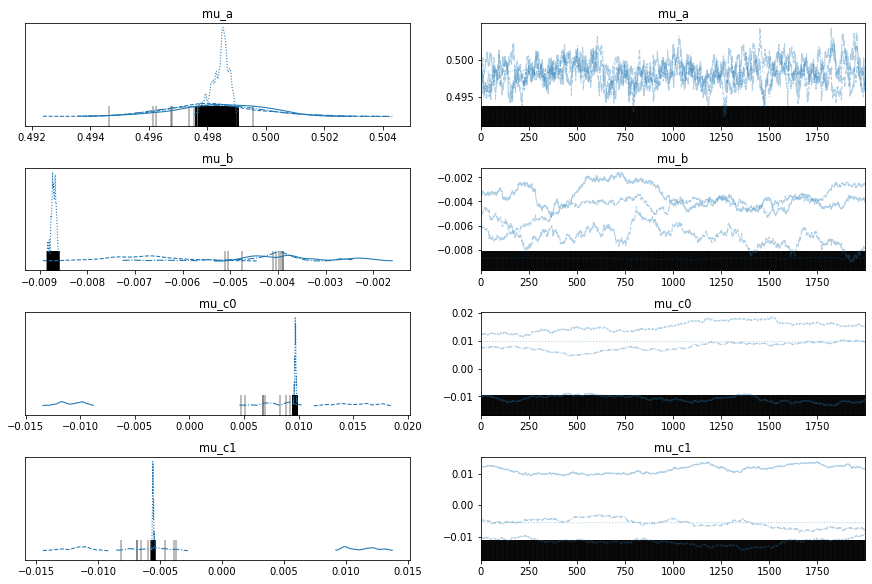

In [82]:
pm.traceplot(hierarchical_trace, var_names=["mu_a", "mu_b", "mu_c0", "mu_c1"]);